In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
import seaborn as sns
from gscripts.general import dataviz
def four_frame(region1, region2, region3, region4, 
               title, output_file, color='red'):
    num_rows = 1
    num_cols = 4
    
        
    with dataviz.Figure(output_file, figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
            
        min_height = min(min(region1),min(region2),min(region3),min(region4))
        max_height = max(max(region1),max(region2),max(region3),max(region4))
            
        linewidth = 2.5
        ax = fig.add_subplot(1,4,1)
        ax.plot(region1, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(three_upstream_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
        sns.despine(ax=ax)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-exon_offset, intron_offset+1, 50))
        ax.set_ylabel("Mean Read Density")
            
        ax = fig.add_subplot(1,4,2)
        ax.plot(region2, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(five_skipped_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
            
        sns.despine(ax=ax, left=True)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-intron_offset, exon_offset+1, 50))
        ax.set_yticklabels([])
            
        ax = fig.add_subplot(1,4,3)
        ax.plot(region3, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(three_skipped_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
            
        sns.despine(ax=ax, left=True)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-exon_offset, intron_offset+1, 50))
        ax.set_yticklabels([])
            
        ax = fig.add_subplot(1,4,4)
        ax.plot(region4, linewidth=linewidth, alpha=.7, color = color)
        # ax.plot(five_downstream_normed_nt, linewidth=linewidth, alpha=.7, color = 'blue')
            
        sns.despine(ax=ax, left=True)
        ax.set_ylim(min_height, max_height)
        # ax.set_xticklabels(np.arange(-intron_offset, exon_offset+1, 50))
        ax.set_yticklabels([])
        plt.suptitle(title,y=1.03)

In [149]:

def entropy_of_reads(density, input_density, min_density_threshold = 0):
    """
    globally for input, add pseudocount of 1 read
    divide each position by 1,000,000
    do en
    plot mean
    """
    ipdf = density.replace(-1, np.nan)
    indf = input_density.replace(-1, np.nan)
    print(ipdf.shape)
    ipdf = ipdf[ipdf.sum(axis=1) > min_density_threshold]
    print(ipdf.shape)
    # ipdf = density[density.sum(axis=1) > min_density_threshold]
    # indf = input_density[input_density.sum(axis=1) > min_density_threshold]
    
    min_ip_read_number = min([item for item in ipdf.unstack().values if item > 0])
    min_in_read_number = min([item for item in indf.unstack().values if item > 0])
    min_read_number = min(min_ip_read_number,min_in_read_number)
    print(min_read_number)
    ipdf = ipdf + min_read_number
    indf = indf + min_read_number
    
    ipdfdiv = ipdf #.div(1000000)
    indfdiv = indf #.div(1000000)
    
    # dft = pd.merge(ipdfdiv,indfdiv,how='left',left_index=True,right_index=True).fillna(min_read_number)
    
    # ipdfdiv = dft.filter(regex='\d+_x')
    # indfdiv = dft.filter(regex='\d+_y')
    
    # ipdfdiv = ipdfdiv.rename(columns=lambda x: x.replace('_x', ''))
    # indfdiv = indfdiv.rename(columns=lambda x: x.replace('_y', ''))
    
    en = ipdfdiv.multiply(np.log2(ipdfdiv.div(indfdiv)))
    
    return en
def pdf_of_entropy_of_reads(density, input_density, min_density_threshold = 0):
    """
    globally for input, add pseudocount of 1 read
    divide each position by 1,000,000
    do en
    do pdf
    
    """
    en = entropy_of_reads(density, input_density, min_density_threshold)
    min_normalized_read_number = abs(min([item for item in en.unstack().values if abs(item) > 0]))
    en = en + min_normalized_read_number
    pdf = en.div(en.sum(axis=1), axis=0)
    
    return pdf
def calculate_pdf(density, min_density_threshold = 0):
    
    df = density.replace(-1, np.nan)
    df = density[density.sum(axis=1) > min_density_threshold]
    #df = densities[densities.sum(axis=1) > min_density_threshold]
    min_normalized_read_number = min([item for item in df.unstack().values if item > 0])
    print(df.shape)
    # df[df.isnull()==False] += min_normalized_read_number
    df = df + min_normalized_read_number
    pdf = df.div(df.sum(axis=1), axis=0)
    pdf[pdf<0] = np.nan
    return pdf # , mean, sem
    
def KLDivergence(density, input_density, min_density_threshold = 0):
    PDF_CONST = 1.0/len(density.columns)
        
    pdf = calculate_pdf(density,min_density_threshold)
    input_pdf = calculate_pdf(input_density,min_density_threshold)
        
    pdft = pd.merge(pdf,input_pdf,how='left',left_index=True,right_index=True)
        
    pdf = pdft.filter(regex='\d+_x')
    pdfi = pdft.filter(regex='\d+_y')
    pdf = pdf.rename(columns=lambda x: x.replace('_x', ''))
    pdfi = pdfi.rename(columns=lambda x: x.replace('_y', '')).fillna(PDF_CONST)

    en = pdf.multiply(np.log2(pdf.div(pdfi)))
        
    return pdf, pdfi, en
def normalize_and_subtract(density, input_density, min_density_threshold = 0):
        
    pdf = calculate_pdf(density,min_density_threshold)
    input_pdf = calculate_pdf(input_density,min_density_threshold)
        
    subtracted = pd.DataFrame(pdf.mean() - input_pdf.mean()).T
      
    return subtracted
    
def normalize_and_per_region_subtract(density, input_density, min_density_threshold = 0):
        
    PDF_CONST = 1.0/len(density.columns)
        
    pdf = calculate_pdf(density, min_density_threshold)
    input_pdf = calculate_pdf(input_density, min_density_threshold)
        
    pdft = pd.merge(pdf,input_pdf, how='left',left_index=True,right_index=True)
        
    pdf = pdft.filter(regex='\d+_x')
    pdfi = pdft.filter(regex='\d+_y')
    
    
    pdf = pdf.rename(columns=lambda x: x.replace('_x', ''))
    pdfi = pdfi.rename(columns=lambda x: x.replace('_y', '')).fillna(PDF_CONST)
        
    subtracted = pdf.sub(pdfi)
  
    return subtracted

In [175]:
"""ip = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/204_01_RBFOX2.ip.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
inp = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/204_01_RBFOX2.input.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)"""
ip = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-23-2016/204_02_RBFOX2.ip.excluded.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
inp = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-23-2016/204_02_RBFOX2.input.excluded.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)

(785, 1400)
(93, 1400)
0.239727899432


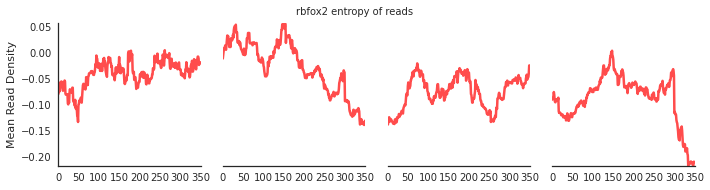

In [176]:
# Entropy of reads
en = entropy_of_reads(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2 entropy of reads', outfile)

(785, 1400)
(93, 1400)
0.239727899432


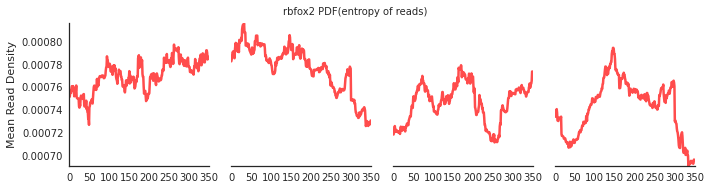

In [177]:
# PDF of entropy of reads (calculate entropy and then get PDF)
en = pdf_of_entropy_of_reads(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2 PDF(entropy of reads)', outfile)

(46, 1400)
(646, 1400)


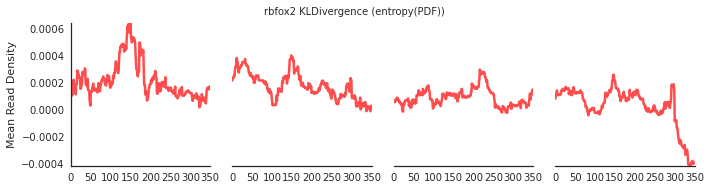

In [178]:
# KLDivergence (entropy)
pdf, input_pdf, en = KLDivergence(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2 KLDivergence (entropy(PDF))', outfile)

(46, 1400)
(646, 1400)


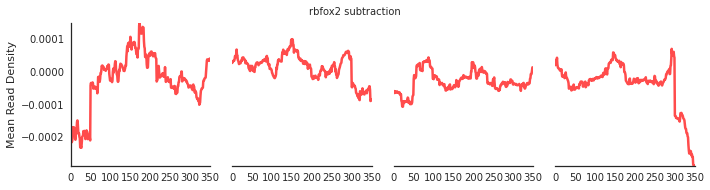

In [179]:
# subtract input from ip
en = normalize_and_subtract(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2 subtraction', outfile)

(46, 1400)
(646, 1400)


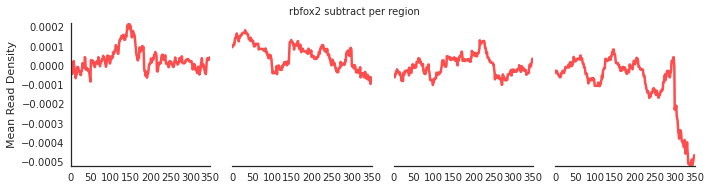

In [180]:
# subtract input from ip per region
en = normalize_and_per_region_subtract(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2 subtract per region', outfile)

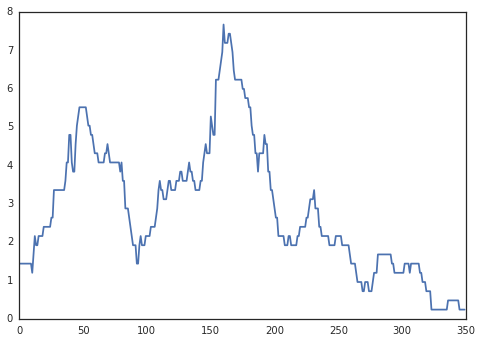

In [181]:
# pd.merge(pdf,input_pdf,how='left',left_index=True,right_index=True)
# pdf.ix['chrX:48368172:48368344:+@chrX:48369754:48369875:+@chrX:48370280:48370323:+']
# plt.plot(ip.ix['chrX:48368172:48368344:+@chrX:48369754:48369875:+@chrX:48370280:48370323:+'])
"""ipn = ip.replace(-1,np.nan)
ipn[ipn.isnull()==False] += 14
ipn"""
# ip.ix['chrX:48368172:48368344:+@chrX:48369754:48369875:+@chrX:48370280:48370323:+']
# pdf.ix['chrX:48368172:48368344:+@chrX:48369754:48369875:+@chrX:48370280:48370323:+']
# x.ix['chrX:48368172:48368344:+@chrX:48369754:48369875:+@chrX:48370280:48370323:+']
# d = calculate_pdf(ip).ix['chrX:48368172:48368344:+@chrX:48369754:48369875:+@chrX:48370280:48370323:+']
# pd.merge(pdf,input_pdf,how='left',left_index=True,right_index=True)
# ip[ip.sum(axis=1)>0].shape
x = pd.read_table('/projects/ps-yeolab3/bay001/maps/se/xintao/8-16-2016/204_02_RBFOX2.ip.excluded.five_downstream.se.raw_density_matrix.csv',
             sep=',',
             index_col=0)
plt.plot(x.ix['chr10:124186458:124186547:+@chr10:124187792:124187832:+@chr10:124189140:124189638:+'])

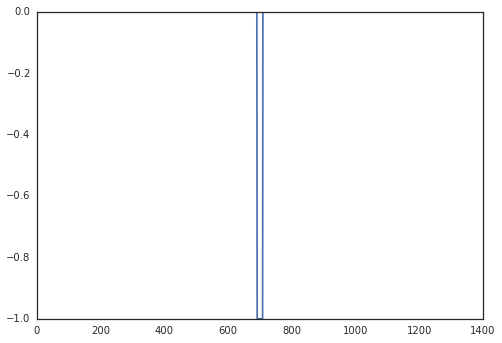

In [182]:
plt.plot(ip.ix['chr10:124186458:124186547:+@chr10:124187792:124187832:+@chr10:124189140:124189638:+'])

# TBRG4 normalization 
### This one we looked at because it looked weird 

In [30]:
ip = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/617_01_TBRG4.ip.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
inp = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/617_01_TBRG4.input.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)

0.184427559376


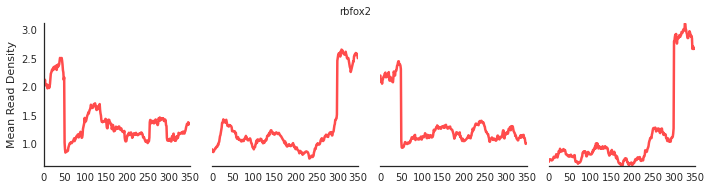

In [31]:
# Entropy of reads
en = entropy_of_reads(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

0.184427559376


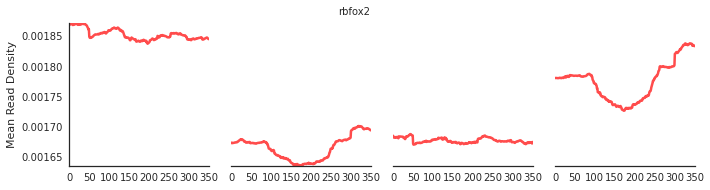

In [32]:
en = pdf_of_entropy_of_reads(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

1.3869818449
0.184427559376


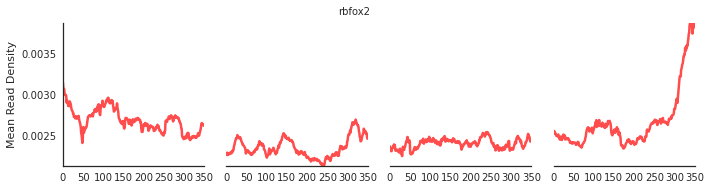

In [33]:
en = KLDivergence(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

1.3869818449
0.184427559376


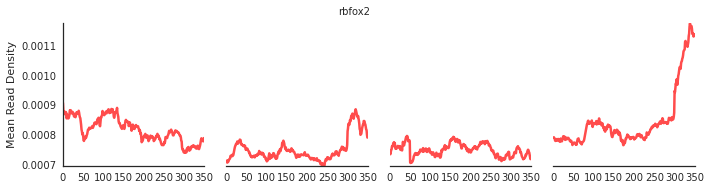

In [34]:
en = normalize_and_subtract(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

In [35]:
en = normalize_and_per_region_subtract(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

KeyboardInterrupt: 

# U2AF2

In [ ]:
ip = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/272_01_U2AF2.ip.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
inp = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/272_01_U2AF2.input.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)

In [ ]:
en = entropy_of_reads(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

In [ ]:
en = pdf_of_entropy_of_reads(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

In [ ]:
en = KLDivergence(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

In [ ]:
en = normalize_and_subtract(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

In [ ]:
en = normalize_and_per_region_subtract(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

# Dividing None by a constant produces a weird result.

In [ ]:
def entropy_of_reads2(density, input_density, min_density_threshold = 0):
    """
    globally for input, add pseudocount of 1 read
    divide each position by 1,000,000
    do en
    plot mean
    """
    ipdf = density.replace(-1, np.nan)
    indf = input_density.replace(-1, np.nan)
    
    # ipdf = density[density.sum(axis=1) > min_density_threshold]
    # indf = input_density[input_density.sum(axis=1) > min_density_threshold]
    
    min_ip_read_number = min([item for item in ipdf.unstack().values if item > 0])
    min_in_read_number = min([item for item in indf.unstack().values if item > 0])
    min_read_number = min(min_ip_read_number,min_in_read_number)
    
    ipdf = ipdf + min_read_number
    indf = indf + min_read_number
    
    ipdfdiv = ipdf.div(1000000)
    indfdiv = indf.div(1000000)
    
    # dft = pd.merge(ipdfdiv,indfdiv,how='left',left_index=True,right_index=True).fillna(min_read_number)
    
    # ipdfdiv = dft.filter(regex='\d+_x')
    # indfdiv = dft.filter(regex='\d+_y')
    
    # ipdfdiv = ipdfdiv.rename(columns=lambda x: x.replace('_x', ''))
    # indfdiv = indfdiv.rename(columns=lambda x: x.replace('_y', ''))
    
    en = ipdfdiv.multiply(np.log2(ipdfdiv.div(indfdiv)))
    
    return ipdfdiv, indfdiv, ipdf, indf, en

ip = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/272_01_U2AF2.ip.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
inp = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/272_01_U2AF2.input.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
ipdfdiv, indfdiv, ipdf, indf, en = entropy_of_reads2(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

# Removing the division fixes it.

In [ ]:
def entropy_of_reads2(density, input_density, min_density_threshold = 0):
    """
    globally for input, add pseudocount of 1 read
    divide each position by 1,000,000
    do en
    plot mean
    """
    ipdf = density.replace(-1, np.nan)
    indf = input_density.replace(-1, np.nan)
    
    # ipdf = density[density.sum(axis=1) > min_density_threshold]
    # indf = input_density[input_density.sum(axis=1) > min_density_threshold]
    
    min_ip_read_number = min([item for item in ipdf.unstack().values if item > 0])
    min_in_read_number = min([item for item in indf.unstack().values if item > 0])
    min_read_number = min(min_ip_read_number,min_in_read_number)
    
    ipdf = ipdf + min_read_number
    indf = indf + min_read_number
    
    ipdfdiv = ipdf # .div(1000000)
    indfdiv = indf # .div(1000000)
    
    
    # dft = pd.merge(ipdfdiv,indfdiv,how='left',left_index=True,right_index=True).fillna(min_read_number)
    
    # ipdfdiv = dft.filter(regex='\d+_x')
    # indfdiv = dft.filter(regex='\d+_y')
    
    # ipdfdiv = ipdfdiv.rename(columns=lambda x: x.replace('_x', ''))
    # indfdiv = indfdiv.rename(columns=lambda x: x.replace('_y', ''))
    
    en = ipdfdiv.multiply(np.log2(ipdfdiv.div(indfdiv)))
    
    return ipdfdiv, indfdiv, ipdf, indf, en

ip = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/272_01_U2AF2.ip.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
inp = pd.read_table('/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/272_01_U2AF2.input.all.feature.se.raw_density_matrix.csv',
                   sep=',',index_col=0)
ipdfdiv, indfdiv, ipdf, indf, en = entropy_of_reads2(ip, inp)
enm = en.mean()
b = {}
b['region1'], b['region2'], b['region3'], b['region4'] = np.array_split(enm,4)
outfile = '/home/bay001/projects/maps_20160420/analysis/tests-8-23-2016/rbfox2.svg'
four_frame(b['region1'], b['region2'], b['region3'], b['region4'], 'rbfox2', outfile)

In [116]:
ip.head()

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
chr10:100148111:100148265:-@chr10:100147622:100147841:-@chr10:100146958:100147064:-,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr10:100150355:100150511:-@chr10:100148111:100148265:-@chr10:100146958:100147064:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr10:100174766:100174978:-@chr10:100174489:100174591:-@chr10:100173705:100174052:-,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr10:100186972:100187021:-@chr10:100185575:100185742:-@chr10:100185298:100185477:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
chr10:100190328:100190427:-@chr10:100189548:100189646:-@chr10:100189330:100189399:-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
ipdf.head()

In [123]:
x = pd.DataFrame()
input_pdf.append(set(pdf.index) - set(input_pdf.index))

TypeError: cannot concatenate a non-NDFrame object

In [126]:
df = pd.DataFrame(np.random.randn(8, 4), columns=['A','B','C','D'])
df

,A,B,C,D
0,0.392289,0.221927,2.302792,-0.794061
1,0.282772,0.582967,-0.713652,1.209416
2,-0.310056,0.317217,0.715891,-0.695234
3,0.450413,-0.517607,0.739365,0.137635
4,1.398501,-0.565512,-0.049826,0.244859
5,0.425928,-0.303737,0.835901,0.486692
6,0.851847,-0.853069,0.431179,0.979272
7,0.895027,-0.728703,-0.080112,-0.406531


In [133]:
x  = df.loc[2] = 0
x

0

In [139]:
woofs = set(pdf.index) - set(input_pdf.index)
df.iloc[[woof for woof in woofs]]=range(0,4)

IndexingError: ['chr16:68033278:68033421:-@chr16:68026853:68027160:-@chr16:68025967:68026096:-', 'chr21:45228682:45232448:-@chr21:45226845:45227120:-@chr21:45225639:45226469:-', 'chr11:8806703:8807009:+@chr11:8808601:8808833:+@chr11:8831624:8831778:+', 'chr19:19917751:19917877:-@chr19:19916840:19916935:-@chr19:19903520:19906469:-', 'chr3:10334526:10334631:-@chr3:10331446:10331559:-@chr3:10327434:10327578:-', 'chr10:38691497:38691780:-@chr10:38681940:38682040:-@chr10:38680911:38681045:-', 'chr8:86290275:86290342:-@chr8:86263960:86264013:-@chr8:86254978:86255054:-', 'chr15:51519976:51520130:-@chr15:51514546:51514722:-@chr15:51510738:51510852:-', 'chr7:135370270:135370431:-@chr7:135368872:135369009:-@chr7:135365987:135366448:-', 'chr22:26743685:26743879:+@chr22:26747018:26747209:+@chr22:26761338:26761532:+', 'chr8:104152921:104153285:+@chr8:104225147:104225313:+@chr8:104240217:104242533:+', 'chr3:158431586:158431648:-@chr3:158428527:158428722:-@chr3:158422580:158422716:-', 'chr9:2622100:2622373:-@chr9:2539399:2539552:-@chr9:2536359:2536453:-', 'chr9:86243788:86243874:+@chr9:86256463:86256506:+@chr9:86258344:86259045:+', 'chr15:38792304:38792340:-@chr15:38790995:38791147:-@chr15:38780302:38782889:-', 'chr2:75155366:75158663:+@chr2:75159326:75159416:+@chr2:75159788:75160151:+', 'chr9:21026595:21026722:-@chr9:21017808:21017909:-@chr9:21015897:21016009:-', 'chr2:152359863:152359955:-@chr2:152353455:152353547:-@chr2:152352790:152352882:-', 'chr3:135684515:135684691:+@chr3:135719901:135722335:+@chr3:135745674:135745940:+', 'chr17:10657546:10657679:+@chr17:10669996:10670173:+@chr17:10671182:10671347:+', 'chr17:56414809:56415040:+@chr17:56416604:56416808:+@chr17:56429096:56429275:+', 'chr1:110931859:110931977:-@chr1:110924274:110924417:-@chr1:110923604:110923765:-', 'chr17:47918914:47918946:-@chr17:47917212:47917271:-@chr17:47915671:47916035:-', 'chr3:193788611:193788759:-@chr3:193770149:193770231:-@chr3:193733340:193733424:-', 'chrX:71458694:71458858:-@chrX:71457681:71457798:-@chrX:71424507:71428548:-', 'chr6:32811863:32812051:+@chr6:32812422:32812647:+@chr6:32813195:32814277:+', 'chr21:46348569:46348753:-@chr21:46340736:46340965:-@chr21:46330640:46330700:-', 'chr21:46348569:46348753:-@chr21:46340736:46340877:-@chr21:46330640:46330700:-', 'chr12:16760870:16761148:-@chr12:16759000:16759066:-@chr12:16753589:16753802:-', 'chr4:141074014:141075233:-@chr4:140810511:140812121:-@chr4:140651570:140651821:-', 'chr1:25633087:25633220:+@chr1:25634138:25634307:+@chr1:25643491:25643570:+', 'chr22:42956192:42956271:+@chr22:42959395:42959487:+@chr22:42962310:42962344:+', 'chr21:33784752:33785321:+@chr21:33825620:33825816:+@chr21:33840004:33840156:+', 'chr11:614476:614534:-@chr11:614174:614399:-@chr11:613785:613865:-', 'chr11:614476:614534:-@chr11:613951:614037:-@chr11:613785:613865:-', 'chr8:94730903:94731016:+@chr8:94736738:94736823:+@chr8:94738622:94738741:+', 'chr2:74648857:74648943:+@chr2:74649247:74649502:+@chr2:74649997:74650059:+', 'chr1:110931859:110931977:-@chr1:110925456:110925588:-@chr1:110923604:110923765:-', 'chr1:118506422:118506561:-@chr1:118497711:118497853:-@chr1:118496288:118496672:-', 'chr16:30066493:30066648:+@chr16:30070262:30070374:+@chr16:30075050:30075569:+', 'chrX:18807239:18807391:+@chrX:18824521:18824663:+@chrX:18836157:18836263:+', 'chr13:46668988:46669137:+@chr13:46671245:46671534:+@chr13:46672533:46675482:+', 'chr2:108998218:108998343:+@chr2:108998841:108998938:+@chr2:108999549:108999675:+', 'chr11:85593556:85593718:+@chr11:85597243:85597410:+@chr11:85606336:85606427:+', 'chr7:17334790:17334897:-@chr7:17331995:17332064:-@chr7:17325901:17326140:-', 'chr21:45230112:45230242:-@chr21:45228682:45229332:-@chr21:45225639:45226469:-', 'chr16:58528868:58528912:+@chr16:58534892:58534981:+@chr16:58537610:58537807:+', 'chr1:142618766:142618856:+@chr1:142619387:142619579:+@chr1:142621001:142621059:+', 'chr11:71791377:71791931:+@chr11:71804542:71804747:+@chr11:71805994:71806142:+', 'chr17:42925270:42925620:+@chr17:42926622:42926756:+@chr17:42927700:42927848:+', 'chr17:43339558:43339710:+@chr17:43343617:43343885:+@chr17:43344480:43344695:+', 'chr10:119799657:119799853:+@chr10:119802952:119803076:+@chr10:119804787:119804868:+', 'chr8:120256535:120256570:-@chr8:120236490:120236552:-@chr8:120235524:120235627:-', 'chr3:187513975:187514151:+@chr3:187522005:187522174:+@chr3:187522616:187523046:+', 'chr13:99910408:99910682:-@chr13:99908582:99908773:-@chr13:99906967:99908160:-', 'chr14:64727167:64727466:-@chr14:64716264:64716397:-@chr14:64701688:64701868:-', 'chr6:30657802:30658020:-@chr6:30657053:30657229:-@chr6:30655824:30656719:-', 'chr22:42968442:42968535:+@chr22:42969640:42969751:+@chr22:42969942:42970388:+', 'chr20:60928068:60928264:+@chr20:60930324:60930536:+@chr20:60931248:60931536:+', 'chr5:55439628:55439756:-@chr5:55422749:55422933:-@chr5:55412442:55412609:-', 'chr6:109081505:109081606:+@chr6:109088199:109088472:+@chr6:109089594:109090773:+', 'chr8:38003481:38003665:-@chr8:38002740:38002833:-@chr8:38000218:38001904:-', 'chr17:48616548:48616676:+@chr17:48617565:48617695:+@chr17:48618154:48618423:+', 'chr4:660320:660403:+@chr4:661645:661730:+@chr4:663835:664681:+', 'chr14:64727167:64727466:-@chr14:64723944:64724082:-@chr14:64701688:64701868:-', 'chr1:15639553:15639683:+@chr1:15642874:15642963:+@chr1:15653555:15653638:+', 'chr10:73572525:73572647:+@chr10:73573001:73573105:+@chr10:73574709:73575704:+', 'chr5:175223610:175223787:+@chr5:175232447:175232624:+@chr5:175235992:175236071:+', 'chr6:146149497:146149592:+@chr6:146202715:146202784:+@chr6:146204341:146207721:+', 'chr3:12353879:12353952:+@chr3:12413350:12413610:+@chr3:12421203:12421430:+', 'chrX:53310678:53310796:-@chrX:53308746:53308841:-@chrX:53295506:53296246:-', 'chr7:17334790:17334897:-@chr7:17330854:17330995:-@chr7:17325901:17326140:-', 'chr17:47921426:47921519:-@chr17:47918914:47918946:-@chr17:47917212:47917271:-', 'chr1:205561268:205561415:+@chr1:205566908:205566978:+@chr1:205568259:205568379:+', 'chr17:29640997:29641130:-@chr17:29634905:29634977:-@chr17:29630788:29632648:-', 'chr16:57734057:57734182:+@chr16:57735848:57736042:+@chr16:57738788:57738946:+', 'chr1:151740534:151740709:+@chr1:151742648:151742733:+@chr1:151743553:151743806:+', 'chr17:41046583:41046651:-@chr17:41036612:41036703:-@chr17:41030544:41031835:-', 'chr21:33867337:33867480:+@chr21:33873725:33873805:+@chr21:33876236:33876325:+', 'chr11:85622324:85622445:+@chr11:85623692:85623784:+@chr11:85626462:85626541:+', 'chr12:122688228:122688348:+@chr12:122689069:122689231:+@chr12:122691277:122691694:+', 'chr15:83440825:83440980:-@chr15:83438502:83438636:-@chr15:83437632:83437782:-', 'chr1:155146360:155146505:+@chr1:155147077:155147117:+@chr1:155147862:155148123:+', 'chr17:26910529:26910667:-@chr17:26909745:26909837:-@chr17:26907027:26907138:-', 'chr21:33867337:33867480:+@chr21:33873725:33873796:+@chr21:33876236:33876325:+', 'chr1:67845669:67845806:+@chr1:67852262:67852352:+@chr1:67861230:67862583:+', 'chr22:30662755:30662829:-@chr22:30660991:30661133:-@chr22:30658819:30660453:-', 'chr14:100625843:100626012:-@chr14:100615305:100616047:-@chr14:100612753:100613244:-', 'chr12:13102424:13103318:-@chr12:13095195:13095262:-@chr12:13093709:13093783:-', 'chr1:54359861:54360220:+@chr1:54371768:54371967:+@chr1:54375604:54376759:+', 'chr2:152390729:152390833:-@chr2:152389956:152390060:-@chr2:152388306:152388410:-', 'chr6:30657824:30658020:-@chr6:30657053:30657247:-@chr6:30655824:30656719:-', 'chr2:233405312:233405421:+@chr2:233406084:233406239:+@chr2:233407133:233407230:+', 'chr22:41613036:41613631:-@chr22:41609634:41610707:-@chr22:41605126:41605955:-', 'chr3:3841121:3841603:+@chr3:3842649:3842930:+@chr3:3886048:3889387:+', 'chr17:16351159:16351274:-@chr17:16350194:16350345:-@chr17:16345328:16347445:-', 'chr3:10331446:10331562:-@chr3:10329709:10329900:-@chr3:10328712:10329010:-', 'chr4:79827262:79827315:-@chr4:79809215:79809302:-@chr4:79808281:79808463:-', 'chr7:56156552:56156668:-@chr7:56155291:56155469:-@chr7:56151343:56151408:-', 'chr15:56841355:56841708:-@chr15:56840645:56840799:-@chr15:56840058:56840205:-', 'chr22:28331139:28331218:+@chr22:28390461:28390641:+@chr22:28393399:28393727:+', 'chr12:50055749:50055832:-@chr12:50052225:50052377:-@chr12:50050865:50050973:-', 'chr6:32811863:32812051:+@chr6:32812422:32812647:+@chr6:32813107:32814277:+', 'chr22:34140116:34140315:+@chr22:34142402:34142444:+@chr22:34143657:34143811:+', 'chr3:43733009:43733086:-@chr3:43694439:43694532:-@chr3:43647206:43647355:-', 'chr17:45909466:45909571:+@chr17:45911335:45911413:+@chr17:45911791:45911899:+', 'chr2:118943807:118943962:-@chr2:118942914:118942966:-@chr2:118940515:118940898:-', 'chr8:6420168:6420784:-@chr8:6389853:6390008:-@chr8:6385076:6385197:-', 'chr6:119288000:119288117:-@chr6:119285832:119285936:-@chr6:119282926:119283128:-', 'chr17:27038588:27038872:-@chr17:27033698:27033781:-@chr17:27031726:27031861:-', 'chr12:6930963:6931066:+@chr12:6932634:6932929:+@chr12:6934649:6934838:+', 'chr3:38163119:38163272:+@chr3:38163562:38163685:+@chr3:38163780:38164228:+', 'chr3:62280375:62280453:-@chr3:62278289:62278392:-@chr3:62247494:62249817:-', 'chr4:38666415:38666430:-@chr4:38637577:38637679:-@chr4:38632121:38632202:-', 'chr7:23637586:23637670:+@chr7:23643705:23643898:+@chr7:23650790:23651172:+', 'chr6:32811863:32812051:+@chr6:32812587:32812647:+@chr6:32813195:32814277:+', 'chr8:54764368:54764624:+@chr8:54852136:54852284:+@chr8:54859225:54859308:+', 'chr1:28203099:28203239:+@chr1:28208482:28209554:+@chr1:28211806:28211962:+', 'chr2:74741124:74741361:+@chr2:74742149:74742333:+@chr2:74742760:74742997:+', 'chr5:131991955:131992322:+@chr5:131992758:131992936:+@chr5:131993982:131994052:+', 'chr2:162105035:162105096:-@chr2:162083560:162083644:-@chr2:162079296:162079994:-', 'chr1:51763463:51763662:-@chr1:51761751:51761842:-@chr1:51760063:51760183:-', 'chr20:34068958:34069076:-@chr20:34065651:34065770:-@chr20:34064199:34064500:-', 'chr12:48535697:48535849:+@chr12:48536565:48536729:+@chr12:48537536:48537597:+', 'chr22:34142402:34142444:+@chr22:34143657:34143811:+@chr22:34146591:34146803:+', 'chr12:53729930:53730004:-@chr12:53729410:53729477:-@chr12:53720360:53723204:-', 'chr16:66608843:66609040:+@chr16:66611007:66611105:+@chr16:66612734:66613038:+', 'chr20:30525199:30525312:+@chr20:30525985:30526066:+@chr20:30526945:30527069:+', 'chr18:641327:641541:+@chr18:644910:645097:+@chr18:649898:650293:+', 'chr3:62303483:62303575:-@chr3:62302781:62302867:-@chr3:62280375:62280453:-', 'chr7:29234693:29234892:-@chr7:29224037:29224164:-@chr7:29220906:29221028:-', 'chr3:196054261:196054462:-@chr3:196053826:196053903:-@chr3:196051142:196051311:-', 'chr8:86290275:86290342:-@chr8:86254978:86255054:-@chr8:86253828:86253888:-', 'chr4:68719786:68719904:-@chr4:68708276:68708343:-@chr4:68703890:68704047:-', 'chr15:59408889:59409125:+@chr15:59409427:59409567:+@chr15:59415716:59415826:+', 'chr1:43638403:43638581:+@chr1:43642792:43642882:+@chr1:43647205:43647521:+', 'chr11:409868:410027:-@chr11:409217:409308:-@chr11:408695:408893:-', 'chr3:62303483:62303575:-@chr3:62302781:62302905:-@chr3:62280375:62280453:-', 'chr10:51555731:51555836:+@chr10:51556751:51556856:+@chr10:51562271:51562518:+', 'chr6:127839724:127840500:-@chr6:127838664:127838911:-@chr6:127836659:127837847:-', 'chr16:3149191:3149293:-@chr16:3142678:3143005:-@chr16:3141765:3141829:-', 'chr2:18768769:18768858:-@chr2:18768209:18768439:-@chr2:18767520:18767657:-', 'chr7:157647277:157647567:+@chr7:157648619:157648822:+@chr7:157649982:157650240:+', 'chr2:55746740:55747052:+@chr2:55747541:55747615:+@chr2:55749238:55749302:+', 'chr1:85014469:85014647:+@chr1:85016115:85016213:+@chr1:85018718:85018807:+', 'chr8:86025167:86025334:+@chr8:86035648:86035841:+@chr8:86037027:86037174:+', 'chr15:78888882:78889074:-@chr15:78886256:78886353:-@chr15:78885395:78885533:-', 'chr2:152372973:152373077:-@chr2:152371332:152371442:-@chr2:152370832:152370942:-', 'chr15:99666927:99666997:+@chr15:99669572:99672018:+@chr15:99672955:99675800:+', 'chr2:27346657:27346930:+@chr2:27351309:27351469:+@chr2:27351813:27351995:+', 'chr7:27179702:27179805:-@chr7:27166505:27166689:-@chr7:27162178:27162261:-', 'chr2:152369247:152369351:-@chr2:152364519:152364623:-@chr2:152363423:152363527:-', 'chr19:50315895:50315993:-@chr19:50315508:50315592:-@chr19:50314888:50314956:-', 'chr21:33840004:33840156:+@chr21:33867337:33867480:+@chr21:33873725:33873805:+', 'chr10:81901838:81901935:+@chr10:81903979:81904099:+@chr10:81904656:81904784:+', 'chr20:34078682:34078808:-@chr20:34068958:34069076:-@chr20:34065651:34065770:-', 'chr10:134010525:134010605:+@chr10:134011919:134011987:+@chr10:134012355:134012475:+', 'chr12:7015573:7015826:+@chr12:7016479:7016609:+@chr12:7023055:7023406:+', 'chr21:35898961:35899261:-@chr21:35897386:35897906:-@chr21:35895835:35896008:-', 'chr16:58543205:58543256:+@chr16:58544549:58544587:+@chr16:58545326:58547523:+', 'chr16:67855002:67855128:+@chr16:67857529:67857622:+@chr16:67858486:67858682:+', 'chr1:67852262:67852352:+@chr1:67855712:67855811:+@chr1:67861230:67862583:+', 'chr14:105958444:105958646:+@chr14:105958916:105959071:+@chr14:105960172:105960270:+', 'chr6:43624314:43624460:+@chr6:43634161:43634257:+@chr6:43638526:43638748:+', 'chr17:18880167:18880302:+@chr17:18916675:18916830:+@chr17:18918362:18918512:+', 'chr15:66198423:66198479:-@chr15:66194834:66194875:-@chr15:66191066:66191272:-', 'chr2:152350675:152350767:-@chr2:152349867:152349959:-@chr2:152348901:152349008:-', 'chr1:161205637:161205767:-@chr1:161203048:161203128:-@chr1:161202597:161202736:-', 'chr14:24615892:24616026:+@chr14:24617041:24617099:+@chr14:24617185:24617331:+', 'chr17:78172198:78172390:+@chr17:78175543:78175669:+@chr17:78175979:78176219:+', 'chr15:78893595:78894606:-@chr15:78888882:78889074:-@chr15:78885395:78885533:-', 'chr17:48616548:48616676:+@chr17:48617608:48617695:+@chr17:48618154:48618423:+', 'chr21:30963432:30963545:-@chr21:30961159:30961362:-@chr21:30959686:30959909:-', 'chr16:68026853:68027160:-@chr16:68026413:68026539:-@chr16:68025967:68026096:-', 'chr16:58528868:58528912:+@chr16:58533048:58534981:+@chr16:58537610:58537807:+', 'chr10:46963840:46964019:-@chr10:46961605:46962112:-@chr10:46959944:46960018:-', 'chr2:18757450:18757634:-@chr2:18745111:18745385:-@chr2:18735989:18737074:-', 'chr3:148885680:148885770:+@chr3:148888258:148888360:+@chr3:148889882:148891305:+', 'chr3:136580589:136580891:-@chr3:136577360:136577445:-@chr3:136565370:136565428:-', 'chr16:67848205:67848304:+@chr16:67858486:67858682:+@chr16:67859040:67859175:+', 'chr19:37314633:37314723:+@chr19:37316282:37316424:+@chr19:37318552:37319013:+', 'chr7:110731062:110731560:+@chr7:110739937:110740018:+@chr7:110762471:110765509:+', 'chr10:102746506:102746732:-@chr10:102743705:102743831:-@chr10:102743512:102743574:-', 'chr19:49166454:49166524:+@chr19:49176396:49176524:+@chr19:49183282:49185502:+', 'chr7:99913408:99913466:+@chr7:99914693:99914778:+@chr7:99917188:99917431:+', 'chr1:89486215:89486426:-@chr1:89485809:89485894:-@chr1:89480970:89481097:-', 'chr15:34261089:34261351:+@chr15:34338741:34339072:+@chr15:34354844:34357287:+', 'chr11:198464:198585:+@chr11:199369:199509:+@chr11:199944:200258:+', 'chr20:60969993:60970070:-@chr20:60969213:60969321:-@chr20:60968496:60968661:-', 'chr14:64957079:64957258:-@chr14:64953832:64953914:-@chr14:64915824:64916356:-', 'chr20:34078682:34078808:-@chr20:34068958:34069076:-@chr20:34064199:34064500:-', 'chr1:11731323:11731449:+@chr1:11731985:11732080:+@chr1:11733334:11733469:+', 'chr15:63889552:63889944:+@chr15:63891353:63891395:+@chr15:63893495:63894620:+', 'chr17:77018896:77019170:+@chr17:77020318:77020576:+@chr17:77040037:77040205:+', 'chr1:89488367:89488549:-@chr1:89486036:89486426:-@chr1:89480970:89481097:-', 'chr12:29301936:29302340:+@chr12:29423345:29423571:+@chr12:29446233:29446408:+', 'chr19:58238759:58238995:-@chr19:58234582:58234708:-@chr19:58233684:58233806:-', 'chr2:242021692:242021779:+@chr2:242026807:242026890:+@chr2:242027780:242027817:+', 'chr22:31318295:31318502:+@chr22:31319233:31319409:+@chr22:31320716:31322640:+', 'chr11:43941136:43941212:-@chr11:43938219:43938471:-@chr11:43933813:43934034:-', 'chr6:131894344:131894479:+@chr6:131897803:131897875:+@chr6:131900251:131900425:+', 'chr6:28321639:28321729:-@chr6:28309523:28309572:-@chr6:28304567:28304720:-', 'chr17:34205532:34205643:-@chr17:34202565:34202646:-@chr17:34198495:34199468:-', 'chr2:28617415:28617539:-@chr2:28610628:28610778:-@chr2:28607276:28610000:-', 'chr1:25629813:25629950:+@chr1:25633087:25633220:+@chr1:25655389:25656936:+', 'chr10:90762786:90762951:+@chr10:90767457:90767594:+@chr10:90770296:90770357:+', 'chr12:29423345:29423571:+@chr12:29444349:29444427:+@chr12:29446233:29446408:+', 'chr4:167810281:167810395:-@chr4:167713321:167713440:-@chr4:167675659:167675880:-', 'chr11:31814986:31815101:-@chr11:31812258:31812408:-@chr11:31806340:31811567:-', 'chr1:1292061:1292084:-@chr1:1290830:1291132:-@chr1:1290624:1290725:-', 'chr2:128403439:128403819:+@chr2:128405633:128405861:+@chr2:128408290:128410213:+', 'chr16:3074182:3074287:-@chr16:3073848:3073969:-@chr16:3073475:3073531:-', 'chr8:54793442:54793644:+@chr8:54852136:54852284:+@chr8:54859225:54859308:+', 'chr19:42927907:42929356:+@chr19:42989287:42989375:+@chr19:43155239:43156171:+', 'chr8:120258970:120259083:-@chr8:120257050:120257082:-@chr8:120256535:120256570:-', 'chr7:72742578:72742695:+@chr7:72743363:72743452:+@chr7:72744153:72744355:+', 'chr15:75917677:75918029:-@chr15:75914683:75914749:-@chr15:75913235:75913397:-', 'chr15:101606845:101606946:+@chr15:101607445:101607592:+@chr15:101608876:101610317:+', 'chr2:113994178:113994298:-@chr2:113992971:113993159:-@chr2:113984732:113984833:-', 'chr10:38691497:38691780:-@chr10:38688552:38688658:-@chr10:38681940:38682040:-', 'chr8:93895212:93895285:+@chr8:93899122:93899171:+@chr8:93933644:93933694:+', 'chr2:71209707:71209827:+@chr2:71211253:71211379:+@chr2:71211741:71212629:+', 'chr1:47608941:47609065:+@chr1:47609434:47609588:+@chr1:47610029:47610135:+', 'chr4:660320:660403:+@chr4:661645:661795:+@chr4:663835:664681:+', 'chr10:74874115:74874206:+@chr10:74879209:74879280:+@chr10:74879776:74879915:+', 'chr10:97959831:97959914:-@chr10:97959239:97959289:-@chr10:97951455:97951848:-', 'chr20:36560037:36560206:+@chr20:36561941:36561991:+@chr20:36572383:36573747:+', 'chrX:49055427:49055492:-@chrX:49050623:49050818:-@chrX:49049729:49049920:-', 'chr15:65242062:65242193:+@chr15:65243169:65243448:+@chr15:65249442:65251041:+', 'chr7:72440488:72440605:+@chr7:72441267:72441356:+@chr7:72442056:72442116:+', 'chr15:38790995:38791147:-@chr15:38786583:38786968:-@chr15:38780302:38782889:-', 'chr17:56606476:56606778:-@chr17:56604043:56604339:-@chr17:56603581:56603674:-', 'chr8:94738622:94738741:+@chr8:94739359:94739472:+@chr8:94740433:94740671:+', 'chr13:48989836:48989946:-@chr13:48978317:48978399:-@chr13:48963707:48963948:-', 'chr6:10802125:10802292:-@chr6:10797849:10798106:-@chr6:10796231:10796542:-', 'chr3:134366277:134366339:-@chr3:134362158:134362220:-@chr3:134348463:134348537:-', 'chr4:15591168:15591302:+@chr4:15597767:15597830:+@chr4:15599030:15599088:+', 'chr2:37423659:37423741:-@chr2:37418300:37418396:-@chr2:37415620:37415690:-', 'chr11:8947010:8947654:-@chr11:8942841:8943062:-@chr11:8941623:8941997:-', 'chr16:58528868:58528912:+@chr16:58533048:58534981:+@chr16:58537702:58537807:+', 'chr5:43514908:43515273:-@chr5:43509247:43509477:-@chr5:43508679:43508768:-', 'chr7:34724164:34724296:+@chr7:34818107:34818177:+@chr7:34851382:34851475:+', 'chr5:137271486:137271598:+@chr5:137272009:137272116:+@chr5:137275779:137276156:+', 'chr7:17330854:17330995:-@chr7:17327376:17327438:-@chr7:17325901:17326140:-', 'chr15:39468954:39469134:+@chr15:39471342:39471495:+@chr15:39472018:39472231:+', 'chr1:142618766:142618856:+@chr1:142619630:142619717:+@chr1:142621001:142621059:+', 'chr14:64727167:64727466:-@chr14:64723944:64724133:-@chr14:64701688:64701868:-', 'chr19:58095628:58095757:+@chr19:58099907:58100033:+@chr19:58101379:58103758:+', 'chr15:51630692:51630795:-@chr15:51630015:51630105:-@chr15:51547715:51547958:-', 'chr1:178839876:178840215:-@chr1:178838249:178838358:-@chr1:178834089:178834937:-', 'chr12:29376598:29376827:+@chr12:29423345:29423571:+@chr12:29446233:29446408:+', 'chr7:27166505:27166639:-@chr7:27164053:27164168:-@chr7:27162178:27162261:-', 'chr7:156437193:156437451:+@chr7:156439148:156439254:+@chr7:156447270:156447412:+', 'chr7:102517914:102518040:-@chr7:102495224:102495307:-@chr7:102473287:102473421:-', 'chr10:38691497:38691780:-@chr10:38688552:38688658:-@chr10:38680911:38681045:-', 'chrX:55057375:55057497:-@chrX:55054184:55054290:-@chrX:55052253:55052448:-', 'chr3:10334526:10334631:-@chr3:10331446:10331562:-@chr3:10327434:10327578:-', 'chr10:118630636:118630803:+@chr10:118633587:118633712:+@chr10:118635576:118635771:+', 'chr1:25634138:25634307:+@chr1:25643491:25643570:+@chr1:25655389:25656936:+', 'chr13:36920568:36920644:+@chr13:36934791:36934877:+@chr13:36939637:36939741:+', 'chr16:66605040:66605173:+@chr16:66611007:66611105:+@chr16:66612750:66613038:+', 'chr12:109278774:109278976:+@chr12:109281226:109281340:+@chr12:109283245:109283321:+', 'chr5:162920449:162920555:-@chr5:162916257:162916389:-@chr5:162909610:162910278:-', 'chr12:6930963:6931066:+@chr12:6932634:6933931:+@chr12:6934649:6934838:+', 'chr16:1889256:1889439:-@chr16:1887785:1887871:-@chr16:1883984:1884367:-', 'chr17:77020251:77020576:+@chr17:77040037:77040205:+@chr17:77042637:77042776:+', 'chr7:34724164:34724296:+@chr7:34818074:34818177:+@chr7:34851382:34851475:+', 'chr4:169815730:169815828:+@chr4:169817700:169817750:+@chr4:169819644:169819865:+', 'chr12:71077907:71078044:-@chr12:71066500:71066756:-@chr12:71056275:71056385:-', 'chr3:135797209:135797295:+@chr3:135797992:135798125:+@chr3:135801107:135801263:+', 'chr7:51085090:51085214:+@chr7:51086054:51086108:+@chr7:51088669:51088982:+', 'chr1:145706686:145706827:-@chr1:145704017:145704343:-@chr1:145698953:145699090:-', 'chr13:101236079:101236251:-@chr13:101185817:101186028:-@chr13:101182418:101184855:-', 'chr6:32811863:32812051:+@chr6:32812587:32812647:+@chr6:32813107:32814277:+', 'chr21:33867337:33867480:+@chr21:33873725:33873848:+@chr21:33876236:33876325:+', 'chr22:23492250:23492341:+@chr22:23494648:23494713:+@chr22:23495220:23495321:+', 'chr14:24540736:24540850:+@chr14:24542708:24542887:+@chr14:24543260:24543334:+', 'chr17:48245735:48245933:+@chr17:48246453:48246615:+@chr17:48248001:48248027:+', 'chrX:48368172:48368344:+@chrX:48369754:48369875:+@chrX:48370280:48370323:+', 'chr6:83872509:83872638:+@chr6:83874379:83874438:+@chr6:83877581:83878475:+', 'chrX:41548996:41549088:+@chrX:41551861:41551989:+@chrX:41554808:41556530:+', 'chr14:24540736:24540850:+@chr14:24542142:24542328:+@chr14:24542708:24542887:+', 'chr10:20017334:20017479:-@chr10:20013856:20013910:-@chr10:20011259:20011351:-', 'chr2:11300751:11300874:+@chr2:11312051:11312171:+@chr2:11317863:11318998:+', 'chr12:109273339:109274000:+@chr12:109278774:109278976:+@chr12:109283245:109283321:+', 'chr1:180897566:180897709:+@chr1:180904251:180905806:+@chr1:180907691:180907847:+', 'chr15:73766173:73766262:+@chr15:73832826:73832909:+@chr15:73843279:73843491:+', 'chr8:22089309:22089851:-@chr8:22086301:22086422:-@chr8:22085706:22085899:-', 'chr16:20693578:20693785:-@chr16:20685366:20685422:-@chr16:20682853:20682993:-', 'chr3:62302781:62302867:-@chr3:62280375:62280453:-@chr3:62247494:62249817:-', 'chr14:68060460:68060669:-@chr14:68059352:68059432:-@chr14:68056023:68056889:-', 'chr15:38798041:38798121:-@chr15:38795473:38795577:-@chr15:38794513:38794622:-', 'chr12:32890799:32890876:+@chr12:32891198:32891230:+@chr12:32892998:32893174:+', 'chr17:16365572:16365700:-@chr17:16351159:16351274:-@chr17:16345328:16347445:-', 'chr1:86374281:86374334:-@chr1:86372877:86372930:-@chr1:86362039:86362092:-', 'chr20:35515858:35515931:+@chr20:35517654:35517806:+@chr20:35521265:35522638:+', 'chr16:15808766:15808938:-@chr16:15802660:15802698:-@chr16:15796992:15797980:-', 'chr17:45104923:45104994:+@chr17:45105646:45105726:+@chr17:45124512:45124630:+', 'chr14:24540736:24540850:+@chr14:24542142:24542313:+@chr14:24542708:24542887:+', 'chr8:23159540:23159676:-@chr8:23156349:23156460:-@chr8:23154410:23155635:-', 'chr13:48978317:48978399:-@chr13:48975434:48975543:-@chr13:48963707:48963948:-', 'chr19:33663254:33663346:+@chr19:33665088:33665202:+@chr19:33666302:33666703:+', 'chr2:219496859:219497035:+@chr2:219498328:219498484:+@chr2:219498828:219498944:+', 'chr2:63273617:63273782:-@chr2:63273172:63273276:-@chr2:63271100:63272578:-', 'chr1:28203099:28203239:+@chr1:28206155:28206565:+@chr1:28208482:28209554:+', 'chr2:18768769:18768858:-@chr2:18768260:18768439:-@chr2:18767520:18767657:-', 'chr12:48119142:48119355:-@chr12:48114536:48114658:-@chr12:48111912:48111977:-', 'chr14:94392622:94392718:-@chr14:94391458:94391684:-@chr14:94389747:94390346:-', 'chr7:157647277:157647567:+@chr7:157649982:157650240:+@chr7:157655237:157658782:+', 'chr1:156616593:156616967:+@chr1:156617300:156617474:+@chr1:156617775:156617902:+', 'chr15:51749483:51750250:+@chr15:51750917:51751126:+@chr15:51752495:51752779:+', 'chr1:114223820:114223958:+@chr1:114224834:114224924:+@chr1:114225519:114228545:+', 'chr11:414823:414999:-@chr11:409868:410027:-@chr11:408695:408893:-', 'chr2:186653370:186662253:+@chr2:186664424:186673860:+@chr2:186678272:186678769:+', 'chr11:414823:414999:-@chr11:408695:408893:-@chr11:408073:408206:-', 'chr5:148786440:148786641:+@chr5:148800044:148800107:+@chr5:148801044:148801164:+', 'chr5:141993524:141993726:-@chr5:141980267:141980370:-@chr5:141971743:141975046:-', 'chr2:74648857:74648943:+@chr2:74649280:74649502:+@chr2:74649997:74650059:+', 'chr7:34724164:34724296:+@chr7:34851382:34851475:+@chr7:34867013:34867214:+', 'chr16:3355512:3355729:-@chr16:3354764:3354944:-@chr16:3348808:3352009:-', 'chr1:28206155:28206565:+@chr1:28208482:28209554:+@chr1:28211806:28211962:+', 'chr6:10784657:10784805:-@chr6:10779559:10779730:-@chr6:10775561:10775692:-', 'chr12:81657010:81657169:-@chr12:81655728:81655819:-@chr12:81652045:81653439:-', 'chr2:44527110:44527229:+@chr2:44528142:44528266:+@chr2:44531282:44531477:+', 'chr3:114074900:114075028:+@chr3:114076015:114076074:+@chr3:114085543:114085728:+', 'chr2:228173920:228174034:+@chr2:228175492:228175664:+@chr2:228176502:228179508:+', 'chr3:62302781:62302867:-@chr3:62299569:62299645:-@chr3:62280375:62280453:-', 'chr16:67848205:67848304:+@chr16:67855002:67855128:+@chr16:67858486:67858682:+', 'chr6:35200962:35201078:+@chr6:35203223:35203270:+@chr6:35205679:35205795:+', 'chr15:38794513:38794622:-@chr15:38793344:38793488:-@chr15:38792304:38792340:-', 'chr15:44090118:44090211:-@chr15:44089343:44089554:-@chr15:44088353:44088425:-', 'chr5:176295785:176295965:+@chr5:176296615:176296782:+@chr5:176297371:176297535:+', 'chr2:128403439:128403819:+@chr2:128405633:128405861:+@chr2:128407586:128407650:+', 'chr11:409868:410027:-@chr11:408894:409101:-@chr11:408073:408206:-', 'chr14:24534167:24534482:+@chr14:24534831:24534959:+@chr14:24535607:24535673:+', 'chr8:86253828:86253888:-@chr8:86249174:86249292:-@chr8:86245754:86245849:-', 'chr1:28206155:28206565:+@chr1:28209024:28209554:+@chr1:28211806:28211962:+', 'chr2:242011211:242011293:+@chr2:242012681:242012779:+@chr2:242021092:242021208:+', 'chr4:57975928:57976136:+@chr4:58054336:58054485:+@chr4:58067299:58067986:+', 'chr7:75124299:75124693:+@chr7:75125997:75126227:+@chr7:75127261:75127319:+', 'chr17:27037889:27038104:-@chr17:27033698:27033781:-@chr17:27031726:27031861:-', 'chr3:10334526:10334631:-@chr3:10332400:10333135:-@chr3:10331446:10331562:-', 'chr16:67848205:67848304:+@chr16:67855002:67855128:+@chr16:67859040:67859175:+', 'chr11:1478185:1478279:+@chr11:1480422:1480466:+@chr11:1482200:1483919:+', 'chr6:32811863:32812051:+@chr6:32812587:32812647:+@chr6:32823915:32823982:+', 'chr5:68665124:68665291:+@chr5:68667281:68667384:+@chr5:68667861:68668044:+', 'chr22:38349054:38349165:-@chr22:38347467:38347529:-@chr22:38343288:38343470:-', 'chr6:28321639:28321729:-@chr6:28321095:28321259:-@chr6:28304567:28304720:-', 'chr12:25216654:25216750:+@chr12:25219299:25219446:+@chr12:25222284:25222365:+', 'chr15:67768034:67768156:+@chr15:67782341:67782402:+@chr15:67786596:67786704:+', 'chr17:19605918:19605987:-@chr17:19587015:19587352:-@chr17:19584851:19584983:-', 'chr3:10334526:10334631:-@chr3:10332400:10333135:-@chr3:10331757:10331893:-', 'chr2:179278390:179278840:+@chr2:179291093:179291407:+@chr2:179295422:179295616:+', 'chr9:115478741:115478821:-@chr9:115477795:115477884:-@chr9:115456411:115456513:-', 'chr2:36943496:36943565:+@chr2:36956569:36956634:+@chr2:36970243:36970399:+', 'chr5:43514908:43515273:-@chr5:43508679:43508768:-@chr5:43505850:43506496:-', 'chr1:210502250:210502448:+@chr1:210522277:210522410:+@chr1:210536196:210536263:+', 'chr4:106744532:106744594:-@chr4:106742216:106742351:-@chr4:106741699:106741758:-', 'chr17:80282458:80282766:-@chr17:80281133:80281192:-@chr17:80280754:80280887:-', 'chr10:91043394:91043648:+@chr10:91046627:91046998:+@chr10:91051744:91051882:+', 'chr6:4122183:4122280:+@chr6:4125213:4126353:+@chr6:4130376:4130595:+', 'chr16:15808766:15808938:-@chr16:15802659:15802698:-@chr16:15796992:15797980:-', 'chr8:101325519:101325600:-@chr8:101324572:101324638:-@chr8:101299729:101300495:-', 'chr14:60519783:60519923:+@chr14:60520593:60520737:+@chr14:60524596:60524740:+', 'chr4:70066138:70066296:+@chr4:70066890:70067002:+@chr4:70076784:70076865:+', 'chr5:150406461:150406578:+@chr5:150406993:150407092:+@chr5:150407470:150408554:+', 'chr12:29423345:29423571:+@chr12:29446233:29446408:+@chr12:29449954:29450133:+', 'chr6:4099234:4099432:+@chr6:4115641:4115897:+@chr6:4122183:4122280:+', 'chr17:47921426:47921519:-@chr17:47917212:47917271:-@chr17:47915671:47916035:-', 'chr19:12781509:12781635:+@chr19:12783277:12783363:+@chr19:12783661:12783728:+', 'chr16:68034351:68034489:-@chr16:68033170:68033651:-@chr16:68026853:68027160:-', 'chr12:122880089:122880212:+@chr12:122881130:122881252:+@chr12:122883843:122884491:+', 'chr17:47921426:47921519:-@chr17:47918914:47918946:-@chr17:47915671:47916035:-', 'chr14:24540736:24540850:+@chr14:24542098:24542313:+@chr14:24542708:24542887:+', 'chr1:36915859:36916086:-@chr1:36913414:36913488:-@chr1:36904357:36904511:-', 'chr16:58528868:58528912:+@chr16:58534892:58534981:+@chr16:58537702:58537807:+', 'chr2:27291500:27291612:+@chr2:27291916:27291962:+@chr2:27292441:27292574:+', 'chr2:203653553:203653810:-@chr2:203651399:203651498:-@chr2:203650641:203650730:-', 'chr3:12586746:12586963:-@chr3:12584679:12584728:-@chr3:12583359:12583521:-', 'chr10:71055389:71055436:+@chr10:71060525:71060617:+@chr10:71103583:71103745:+', 'chr20:57089715:57089949:-@chr20:57088873:57089043:-@chr20:57045665:57045803:-', 'chr11:624213:624263:-@chr11:621812:621904:-@chr11:621562:621663:-', 'chr2:152361992:152362084:-@chr2:152350675:152350767:-@chr2:152348901:152349008:-', 'chr13:77650949:77651066:+@chr13:77657143:77657245:+@chr13:77661685:77661911:+', 'chr11:71791377:71791931:+@chr11:71799343:71799426:+@chr11:71804542:71804747:+', 'chr17:79977734:79977785:-@chr17:79977517:79977570:-@chr17:79977169:79977257:-', 'chr15:75917677:75918029:-@chr15:75914683:75914831:-@chr15:75913235:75913397:-', 'chr14:24775580:24775729:-@chr14:24775153:24775343:-@chr14:24774393:24774971:-', 'chr21:40817651:40817703:-@chr21:40811560:40811699:-@chr21:40807346:40807499:-', 'chr17:41623229:41623305:-@chr17:41622926:41623036:-@chr17:41622642:41622735:-', 'chr1:36887751:36887820:-@chr1:36886077:36886216:-@chr1:36884592:36884655:-', 'chr16:66608843:66609040:+@chr16:66611007:66611105:+@chr16:66612750:66613038:+', 'chr12:120659426:120659561:-@chr12:120653363:120653464:-@chr12:120652906:120653076:-', 'chr10:46970442:46970601:-@chr10:46969249:46969453:-@chr10:46968581:46968723:-', 'chr20:34078682:34078808:-@chr20:34065651:34065770:-@chr20:34064199:34064500:-', 'chr12:56224480:56224608:-@chr12:56223273:56223420:-@chr12:56221036:56222498:-', 'chr6:10775561:10775692:-@chr6:10773267:10773341:-@chr6:10770344:10770463:-', 'chr1:204957761:204957934:+@chr1:204971724:204971876:+@chr1:204978685:204978816:+', 'chr16:3149191:3149293:-@chr16:3142543:3143005:-@chr16:3141765:3141829:-', 'chr20:21194549:21194660:-@chr20:21194174:21194230:-@chr20:21182953:21183011:-', 'chr15:93616145:93616260:-@chr15:93609061:93609488:-@chr15:93595223:93595737:-', 'chr11:125821687:125821968:+@chr11:125823982:125824106:+@chr11:125825510:125825562:+', 'chr11:102816375:102816478:-@chr11:102815848:102815965:-@chr11:102813721:102815095:-', 'chr11:414823:414999:-@chr11:409860:410027:-@chr11:408695:408893:-', 'chr2:113994178:113994298:-@chr2:113992971:113993080:-@chr2:113984732:113984833:-', 'chr21:33665304:33665443:+@chr21:33671273:33671388:+@chr21:33678951:33679050:+', 'chr8:38261911:38262024:+@chr8:38264464:38264556:+@chr8:38264880:38264981:+', 'chr16:47178234:47178405:+@chr16:47187543:47187707:+@chr16:47191466:47191515:+', 'chr3:11421446:11421526:+@chr3:11468278:11468400:+@chr3:11596285:11599139:+', 'chr15:93616145:93616260:-@chr15:93609330:93609484:-@chr15:93595223:93595737:-', 'chr6:28309523:28309572:-@chr6:28305533:28305670:-@chr6:28304567:28304720:-', 'chr6:32811863:32812051:+@chr6:32812422:32812647:+@chr6:32823915:32823982:+', 'chr15:89848836:89848929:+@chr15:89849241:89849425:+@chr15:89850707:89850760:+', 'chr9:115480267:115480387:-@chr9:115478741:115478821:-@chr9:115456411:115456513:-', 'chr12:75875614:75875859:+@chr12:75884186:75884298:+@chr12:75889357:75889442:+', 'chr22:34123477:34123618:+@chr22:34128242:34129671:+@chr22:34133550:34133769:+', 'chr15:89848836:89848929:+@chr15:89849238:89849425:+@chr15:89850707:89850760:+', 'chr7:34724164:34724296:+@chr7:34818074:34818177:+@chr7:34867013:34867214:+', 'chr6:28321639:28321729:-@chr6:28305533:28305670:-@chr6:28304567:28304720:-', 'chr15:74646797:74647026:+@chr15:74648624:74648816:+@chr15:74653855:74656961:+', 'chr4:81504247:81504337:+@chr4:81560872:81560989:+@chr4:81791147:81791289:+', 'chr1:43919084:43919168:-@chr1:43918574:43918675:-@chr1:43917876:43917990:-', 'chr9:115456411:115456513:-@chr9:115451807:115451897:-@chr9:115448791:115449913:-', 'chr2:152357905:152357997:-@chr2:152355812:152355904:-@chr2:152354774:152354866:-', 'chr1:25629813:25629950:+@chr1:25633087:25633220:+@chr1:25643491:25643570:+', 'chr1:89486215:89486426:-@chr1:89485813:89485894:-@chr1:89480970:89481097:-', 'chr9:139693554:139693675:+@chr9:139694165:139694242:+@chr9:139694454:139694621:+', 'chr22:34121598:34121742:+@chr22:34122102:34122183:+@chr22:34123477:34123618:+', 'chr22:42954354:42954463:+@chr22:42956192:42956271:+@chr22:42967127:42967209:+', 'chr14:24779855:24780576:-@chr14:24779613:24779754:-@chr14:24777685:24778036:-', 'chr6:10775561:10775692:-@chr6:10770344:10770463:-@chr6:10762956:10764839:-', 'chr5:139488058:139488215:-@chr5:139485881:139486075:-@chr5:139485172:139485347:-', 'chr12:49621709:49621949:+@chr12:49650180:49650294:+@chr12:49651667:49651784:+', 'chr3:128211742:128212030:-@chr3:128210847:128211065:-@chr3:128205646:128205919:-', 'chr3:10334526:10334631:-@chr3:10331446:10331562:-@chr3:10328388:10328496:-', 'chr2:86831130:86831486:+@chr2:86832366:86832558:+@chr2:86844299:86845889:+', 'chr4:4389331:4389485:+@chr4:4393202:4393318:+@chr4:4411300:4411410:+', 'chr14:50801283:50801339:-@chr14:50798980:50799150:-@chr14:50796720:50796899:-', 'chr20:30525199:30525312:+@chr20:30526945:30527069:+@chr20:30530748:30530858:+', 'chr3:193345018:193345121:-@chr3:193337390:193337475:-@chr3:193336398:193336699:-', 'chr19:42927907:42929356:+@chr19:42989248:42989375:+@chr19:43155239:43156171:+', 'chr3:178525131:178525253:+@chr3:178542346:178542470:+@chr3:178543376:178543546:+', 'chr2:210905144:210905251:-@chr2:210896145:210896270:-@chr2:210894527:210894642:-', 'chr16:31374486:31374695:+@chr16:31381302:31381419:+@chr16:31382405:31382535:+', 'chr17:56606476:56606778:-@chr17:56604128:56604339:-@chr17:56603581:56603674:-', 'chr21:33784752:33785321:+@chr21:33825620:33825816:+@chr21:33829905:33830028:+', 'chr17:74536587:74536655:+@chr17:74538635:74538715:+@chr17:74539111:74539203:+', 'chr11:119293823:119293882:-@chr11:119291579:119291639:-@chr11:119290761:119291096:-', 'chr17:56414809:56415040:+@chr17:56423641:56423704:+@chr17:56429096:56429275:+', 'chr3:98451270:98451495:-@chr3:98437263:98437365:-@chr3:98434494:98434621:-', 'chr3:10331446:10331562:-@chr3:10328388:10328496:-@chr3:10327434:10327578:-', 'chr10:126392194:126392900:+@chr10:126396420:126396559:+@chr10:126402003:126403329:+', 'chr5:141993524:141993726:-@chr5:141980267:141980365:-@chr5:141971743:141975046:-', 'chr5:141993524:141993726:-@chr5:141980267:141980370:-@chr5:141971743:141975049:-', 'chr22:38380346:38380539:-@chr22:38379364:38379875:-@chr22:38373874:38374142:-', 'chr13:76209965:76210130:-@chr13:76196396:76196439:-@chr13:76192906:76193042:-', 'chr9:35041102:35041153:+@chr9:35042408:35042482:+@chr9:35042858:35045988:+', 'chr12:57634462:57634475:-@chr12:57631588:57631696:-@chr12:57630812:57631118:-', 'chr15:73020281:73020335:+@chr15:73021957:73022025:+@chr15:73023646:73023798:+', 'chr10:96972615:96972697:+@chr10:96974609:96974732:+@chr10:96979648:96979728:+', 'chr1:67845669:67845806:+@chr1:67855712:67855811:+@chr1:67861230:67862583:+', 'chr2:231988127:231988844:-@chr2:231978443:231978643:-@chr2:231972950:231974123:-', 'chr1:155170491:155170617:+@chr1:155172914:155173062:+@chr1:155174826:155175286:+', 'chr6:4122183:4122280:+@chr6:4125194:4126353:+@chr6:4130376:4130595:+', 'chr1:153606434:153606568:-@chr1:153605512:153605633:-@chr1:153604510:153604716:-', 'chr3:37826468:37826569:+@chr3:37845314:37845433:+@chr3:37860382:37861281:+', 'chr6:114500189:114500321:+@chr6:114551321:114551487:+@chr6:114556794:114556935:+', 'chr1:28203099:28203239:+@chr1:28206155:28206565:+@chr1:28209024:28209554:+', 'chr21:40801057:40801137:-@chr21:40800098:40800429:-@chr21:40794902:40795416:-', 'chr16:10864129:10864188:-@chr16:10859895:10860010:-@chr16:10857415:10857620:-', 'chr7:110731062:110731560:+@chr7:110737083:110737189:+@chr7:110739937:110740018:+', 'chr15:66201372:66201473:-@chr15:66198963:66199008:-@chr15:66198423:66198479:-', 'chr10:14964980:14965068:-@chr10:14962379:14962443:-@chr10:14961737:14961831:-', 'chr6:28321639:28321729:-@chr6:28305576:28305670:-@chr6:28304567:28304720:-', 'chr12:110959982:110960216:+@chr12:110968330:110968438:+@chr12:110969379:110969891:+', 'chr1:151739639:151739775:+@chr1:151740534:151740709:+@chr1:151742648:151742733:+', 'chr1:161205637:161205767:-@chr1:161202597:161202736:-@chr1:161201119:161201264:-', 'chr7:73635034:73635064:+@chr7:73635967:73636022:+@chr7:73638054:73638113:+', 'chr4:15591168:15591302:+@chr4:15597708:15597830:+@chr4:15599030:15599088:+', 'chr21:34182884:34182964:-@chr21:34179952:34180026:-@chr21:34162984:34166796:-', 'chr15:101586186:101586357:+@chr15:101588699:101588862:+@chr15:101589849:101589988:+', 'chr1:2428267:2428449:+@chr1:2428941:2429048:+@chr1:2429962:2430086:+', 'chr2:211294089:211294175:+@chr2:211307266:211307423:+@chr2:211325199:211325606:+', 'chr7:72742578:72742695:+@chr7:72743363:72743837:+@chr7:72744153:72744355:+', 'chr6:111631056:111631302:-@chr6:111629217:111629448:-@chr6:111628564:111628773:-', 'chr7:86273230:86274188:+@chr7:86415577:86416432:+@chr7:86468155:86469221:+', 'chr20:36531499:36531873:+@chr20:36560037:36560206:+@chr20:36572383:36573747:+', 'chr12:49982237:49982406:-@chr12:49981345:49981535:-@chr12:49976658:49976892:-', 'chr7:1200010:1200259:+@chr7:1203088:1203131:+@chr7:1203797:1205594:+', 'chr3:98451270:98451495:-@chr3:98437268:98437365:-@chr3:98434494:98434621:-', 'chr7:156433441:156433698:+@chr7:156435671:156435781:+@chr7:156436495:156436586:+', 'chr3:169797562:169797685:+@chr3:169801153:169801310:+@chr3:169801693:169803183:+', 'chr19:58989454:58989548:+@chr19:58991010:58991094:+@chr19:58991297:58991386:+', 'chr7:43978030:43978093:+@chr7:43982553:43982702:+@chr7:43988231:43988336:+', 'chr1:145715526:145715565:-@chr1:145710179:145710284:-@chr1:145706686:145706827:-', 'chr8:38008273:38008600:-@chr8:38006159:38006272:-@chr8:38005718:38005845:-', 'chr1:1890559:1890648:-@chr1:1888059:1888223:-@chr1:1884752:1887289:-', 'chr11:66045672:66046008:+@chr11:66048888:66049045:+@chr11:66049730:66049798:+', 'chr12:16762668:16762758:-@chr12:16759000:16759066:-@chr12:16753589:16753802:-', 'chr10:46970442:46970601:-@chr10:46968581:46968723:-@chr10:46967426:46967721:-', 'chr15:75918007:75918446:-@chr15:75914683:75914831:-@chr15:75913235:75913397:-', 'chr11:619306:619390:-@chr11:618599:619162:-@chr11:617954:618111:-', 'chr3:10334526:10334631:-@chr3:10328388:10328496:-@chr3:10327434:10327578:-', 'chr17:29648513:29648767:-@chr17:29647391:29647531:-@chr17:29643428:29646041:-', 'chr15:65235680:65235778:+@chr15:65236849:65236944:+@chr15:65239624:65239813:+', 'chr20:60928066:60928391:+@chr20:60930324:60930536:+@chr20:60931248:60931536:+', 'chr10:38691497:38691780:-@chr10:38688550:38688658:-@chr10:38682535:38682584:-', 'chr7:34724164:34724296:+@chr7:34818107:34818177:+@chr7:34867013:34867214:+', 'chr2:166790367:166790586:+@chr2:166791244:166791299:+@chr2:166803707:166803851:+', 'chr6:32150345:32150475:-@chr6:32150024:32150113:-@chr6:32149383:32149409:-', 'chr3:112738379:112738553:+@chr3:112780634:112780857:+@chr3:112807470:112807871:+', 'chr1:41483307:41483828:-@chr1:41482906:41483049:-@chr1:41481269:41481900:-', 'chr19:38056933:38056991:+@chr19:38058520:38058652:+@chr19:38060752:38060898:+', 'chr4:81504247:81504337:+@chr4:81560872:81560989:+@chr4:81570054:81570360:+', 'chr1:25633087:25633220:+@chr1:25643491:25643570:+@chr1:25655389:25656936:+', 'chr4:139089871:139089972:+@chr4:139092687:139092860:+@chr4:139095626:139095761:+', 'chr11:8474369:8474453:-@chr11:8462225:8462300:-@chr11:8457574:8457686:-', 'chr19:1531737:1531882:+@chr19:1533930:1534040:+@chr19:1535064:1535455:+', 'chr9:140040178:140040354:+@chr9:140042604:140042666:+@chr9:140043461:140043561:+', 'chr7:43978030:43978093:+@chr7:43982553:43982630:+@chr7:43988231:43988336:+', 'chr14:68060460:68060669:-@chr14:68059352:68059435:-@chr14:68056023:68056889:-', 'chr1:110931859:110931977:-@chr1:110925456:110925588:-@chr1:110924274:110924417:-', 'chr14:24615892:24616026:+@chr14:24616907:24617099:+@chr14:24617185:24617331:+', 'chr4:139025661:139026945:+@chr4:139080962:139081046:+@chr4:139089871:139089972:+', 'chr9:129884594:129885044:-@chr9:129870194:129871059:-@chr9:129856012:129856205:-', 'chr3:180334069:180334151:-@chr3:180332784:180332865:-@chr3:180331602:180331652:-', 'chr4:174312324:174312579:-@chr4:174310746:174311043:-@chr4:174309299:174309546:-', 'chr11:619306:619390:-@chr11:618599:619180:-@chr11:617954:618111:-', 'chr22:42956192:42956271:+@chr22:42962310:42962344:+@chr22:42967127:42967209:+', 'chr12:70963455:70963718:-@chr12:70960215:70960484:-@chr12:70956624:70956887:-', 'chr11:118398187:118398327:+@chr11:118398637:118398771:+@chr11:118399318:118399506:+', 'chr15:93616145:93616260:-@chr15:93595223:93595737:-@chr15:93586636:93588935:-', 'chr10:128973476:128974664:-@chr10:128952116:128952187:-@chr10:128933690:128936284:-', 'chr3:114076015:114076074:+@chr3:114078196:114078355:+@chr3:114085543:114085728:+', 'chr8:86263960:86264013:-@chr8:86254978:86255054:-@chr8:86253828:86253888:-', 'chr13:79179436:79179579:+@chr13:79181107:79181345:+@chr13:79189810:79191460:+', 'chr9:138676607:138676735:+@chr9:138677156:138677176:+@chr9:138678043:138678367:+', 'chr1:25633087:25633220:+@chr1:25634138:25634307:+@chr1:25655389:25656936:+', 'chr5:95748022:95748194:-@chr5:95746478:95746690:-@chr5:95743927:95744027:-', 'chr11:75921516:75921803:-@chr11:75917919:75917999:-@chr11:75917369:75917542:-', 'chr10:102746506:102746732:-@chr10:102743791:102743831:-@chr10:102743512:102743574:-', 'chr6:28309523:28309572:-@chr6:28305576:28305670:-@chr6:28304567:28304720:-', 'chr9:35041139:35041437:+@chr9:35042408:35042482:+@chr9:35042858:35045988:+', 'chr9:138678043:138678367:+@chr9:138679946:138680008:+@chr9:138683643:138683727:+', 'chr12:7016479:7016609:+@chr12:7019054:7019190:+@chr12:7023055:7023406:+', 'chr12:107168468:107168609:-@chr12:106901406:106901588:-@chr12:106893854:106893960:-', 'chr21:34185902:34186053:-@chr21:34182884:34182964:-@chr21:34162984:34166796:-', 'chr2:18768769:18768858:-@chr2:18768260:18768388:-@chr2:18767520:18767657:-', 'chrX:48368172:48368344:+@chrX:48369683:48369875:+@chrX:48370280:48370323:+', 'chr10:18795400:18795476:+@chr10:18803165:18803298:+@chr10:18807265:18807345:+', 'chr1:28203099:28203239:+@chr1:28209024:28209554:+@chr1:28211806:28211962:+', 'chr8:120258970:120259083:-@chr8:120257050:120257215:-@chr8:120256535:120256570:-', 'chr4:113569810:113569859:-@chr4:113568571:113568623:-@chr4:113567632:113568124:-', 'chr22:34133550:34133769:+@chr22:34139122:34139185:+@chr22:34140116:34140315:+', 'chr7:99332646:99332819:-@chr7:99250176:99250402:-@chr7:99247696:99247855:-', 'chr13:49227865:49228153:+@chr13:49270662:49270762:+@chr13:49280953:49283498:+', 'chr15:43498528:43498827:-@chr15:43495313:43495473:-@chr15:43494042:43494175:-', 'chr11:409868:410027:-@chr11:408695:408893:-@chr11:408073:408206:-', 'chr10:13696416:13696512:-@chr10:13693903:13693974:-@chr10:13685706:13689035:-', 'chr14:64723944:64724082:-@chr14:64716264:64716397:-@chr14:64701688:64701868:-', 'chr11:47711628:47712410:-@chr11:47707445:47707601:-@chr11:47703521:47703647:-', 'chr16:66605040:66605173:+@chr16:66608843:66609040:+@chr16:66611007:66611105:+', 'chr8:142450326:142450469:-@chr8:142446786:142446962:-@chr8:142446013:142446168:-', 'chr20:36149607:36149805:+@chr20:36150760:36150840:+@chr20:36151069:36152090:+', 'chr6:30657824:30658020:-@chr6:30657053:30657229:-@chr6:30655824:30656719:-', 'chr1:28203099:28203239:+@chr1:28206155:28206565:+@chr1:28211806:28211962:+', 'chr7:43988231:43988336:+@chr7:43990198:43990291:+@chr7:43992249:43995735:+', 'chr11:13007587:13007691:-@chr11:13005773:13005885:-@chr11:13001585:13002456:-', 'chr7:17337976:17338070:-@chr7:17334790:17334897:-@chr7:17325901:17326140:-', 'chr7:141645141:141645200:-@chr7:141643696:141643764:-@chr7:141635614:141635750:-', 'chr11:1478185:1478279:+@chr11:1480422:1480469:+@chr11:1482200:1483919:+', 'chr3:10334526:10334631:-@chr3:10331446:10331559:-@chr3:10328388:10328496:-', 'chr22:28331139:28331218:+@chr22:28336008:28336159:+@chr22:28393399:28393727:+', 'chr17:60548294:60548439:+@chr17:60554857:60555058:+@chr17:60558485:60558567:+', 'chr15:75917677:75918029:-@chr15:75917056:75917276:-@chr15:75913235:75913397:-', 'chr20:30525199:30525312:+@chr20:30525962:30526066:+@chr20:30526945:30527069:+', 'chr17:18880167:18880302:+@chr17:18916723:18916830:+@chr17:18918362:18918512:+', 'chr14:51360300:51360476:+@chr14:51362282:51362440:+@chr14:51368547:51368629:+', 'chr2:10915104:10915197:+@chr2:10917711:10917848:+@chr2:10918698:10918795:+', 'chr9:136255310:136255380:+@chr9:136256457:136256572:+@chr9:136259418:136259536:+', 'chr6:109080621:109080748:+@chr6:109081505:109081606:+@chr6:109088199:109088472:+', 'chr13:50589390:50590207:+@chr13:50592959:50593056:+@chr13:50594350:50595058:+', 'chr16:4292008:4292081:-@chr16:4256728:4258105:-@chr16:4254534:4254635:-', 'chr7:86415577:86416432:+@chr7:86468155:86469221:+@chr7:86479686:86479860:+', 'chr1:153589329:153589462:-@chr1:153588771:153588831:-@chr1:153588305:153588412:-', 'chr11:414823:414999:-@chr11:409868:410027:-@chr11:408073:408206:-', 'chr2:233449016:233449247:-@chr2:233446694:233446851:-@chr2:233445658:233446014:-', 'chr1:89488367:89488549:-@chr1:89486215:89486426:-@chr1:89480970:89481097:-', 'chr5:55455660:55455720:-@chr5:55439628:55439756:-@chr5:55422749:55422933:-', 'chr5:151304055:151304397:-@chr5:151271872:151271999:-@chr5:151266282:151266349:-', 'chr5:141993524:141993726:-@chr5:141980267:141980365:-@chr5:141971743:141975049:-', 'chr8:54764368:54764624:+@chr8:54859225:54859308:+@chr8:54866636:54866870:+', 'chr9:35825227:35825370:-@chr9:35821435:35821625:-@chr9:35819887:35819997:-', 'chr16:67855002:67855128:+@chr16:67858486:67858682:+@chr16:67859040:67859175:+', 'chr2:71175357:71175740:-@chr2:71174664:71174801:-@chr2:71168947:71169563:-', 'chr1:28199055:28199176:+@chr1:28206155:28206565:+@chr1:28209024:28209554:+', 'chr6:4122183:4122280:+@chr6:4126146:4126353:+@chr6:4130376:4130595:+', 'chr16:66605040:66605173:+@chr16:66611007:66611105:+@chr16:66612734:66613038:+', 'chr15:38792304:38792340:-@chr15:38790995:38791385:-@chr15:38780302:38782889:-', 'chr1:6524435:6524513:-@chr1:6522923:6523030:-@chr1:6522689:6522723:-', 'chr11:59387887:59387945:+@chr11:59402893:59403005:+@chr11:59406793:59407334:+', 'chr11:74641345:74641417:-@chr11:74638436:74638533:-@chr11:74632259:74632392:-', 'chr17:29111325:29111461:-@chr17:29101110:29101362:-@chr17:29100425:29100515:-', 'chr19:38042273:38042567:+@chr19:38056933:38056991:+@chr19:38060752:38060898:+', 'chr17:29645326:29645658:-@chr17:29640997:29641062:-@chr17:29630788:29632648:-', 'chr1:110923604:110923765:-@chr1:110921475:110921978:-@chr1:110919572:110919783:-', 'chr9:4576569:4576763:+@chr9:4583038:4583172:+@chr9:4585312:4587469:+']

In [148]:
set(pdf.index) - set(input_pdf.index)

set()